# **Preparation**

In [ ]:
# Import library utama
import os, shutil, random
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow.keras.backend as K

# **Data Wrangling**

## **Data Gathering**

In [ ]:
# Install gdown untuk load data dari GDrive
!pip install gdown

In [ ]:
# Unduk dataset sel darah malaria
# URL https://drive.google.com/file/d/1DUWlxWBxYPYdOPgJZrHrxXW883NhLkFL/view?usp=sharing
output_parasitized = "parasitized.zip"
if not os.path.exists(output_parasitized):
  print(f"Mengunduh {output_parasitized}...")
  !gdown --id 1DUWlxWBxYPYdOPgJZrHrxXW883NhLkFL --output {output_parasitized}
else:
  print(f"{output_parasitized} sudah ada.")

# Unduh dataset sel darah masking
# URL https://drive.google.com/file/d/1fK0_Ms4qcxPVacow-rn7xli2v4kD3-u3/view?usp=sharing
output_masking = "masking.zip"
if not os.path.exists(output_masking):
  print(f"Mengunduh {output_masking}...")
  !gdown --id 1fK0_Ms4qcxPVacow-rn7xli2v4kD3-u3 --output {output_masking}
else:
  print(f"{output_masking} sudah ada.")

Mengunduh parasitized.zip...
/usr/local/lib/python3.11/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1DUWlxWBxYPYdOPgJZrHrxXW883NhLkFL
From (redirected): https://drive.google.com/uc?id=1DUWlxWBxYPYdOPgJZrHrxXW883NhLkFL&confirm=t&uuid=c1c9ad56-6d06-4c96-b942-1fb84c7f317e
To: /content/parasitized.zip
100% 708M/708M [00:12<00:00, 55.1MB/s]
Mengunduh masking.zip...
/usr/local/lib/python3.11/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1fK0_Ms4qcxPVacow-rn7xli2v4kD3-u3
To: /content/masking.zip
100% 663k/663k [00:00<00:00, 145MB/s]


In [ ]:
# Ekstrak file dataset sel darah malaria
!unzip -q parasitized.zip -d /content/

# Ekstrak file dataset sel darah masking
!unzip -q masking.zip -d /content/generated_masks/

In [ ]:
# Hapus folder jika dibutuhkan
# shutil.rmtree('/content/cell_images/')
# shutil.rmtree('/content/generated_masks/')

# **Image Processing**

In [ ]:
# Simpan dataset dari direktori ke variabel
image_dir = "/content/cell_images/Parasitized"
mask_dir = "/content/generated_masks"

In [ ]:
# Tentukan ukuran gambar
IMG_HEIGHT = 128
IMG_WIDTH = 128

In [ ]:
# Simpan ke dalam list data fitur (X) dan target (Y)
X = []
Y = []

In [ ]:
# Ambil data gambar masking
files = sorted(os.listdir(mask_dir))

# Preprocessing gambar
for fname in files:
    img_path = os.path.join(image_dir, fname)
    mask_path = os.path.join(mask_dir, fname)

    img = cv2.imread(img_path)
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

    if img is None or mask is None:
        continue

    img = cv2.resize(img, (IMG_WIDTH, IMG_HEIGHT))
    mask = cv2.resize(mask, (IMG_WIDTH, IMG_HEIGHT))

    # Scaling
    img = img / 255.0
    mask = (mask > 127).astype(np.float32)
    mask = np.expand_dims(mask, axis=-1)

    X.append(img)
    Y.append(mask)

In [ ]:
# Ubah ke dalam representasi vaktor angka
X = np.array(X)
Y = np.array(Y)

print(f"Total data: {X.shape[0]}")

Total data: 1000


# **Model Training**

## **Spit Data**

In [ ]:
X_train, X_temp, Y_train, Y_temp = train_test_split(X, Y, test_size=0.3, random_state=42)
X_val, X_test, Y_val, Y_test = train_test_split(X_temp, Y_temp, test_size=0.5, random_state=42)

print(f"Train: {X_train.shape}, Val: {X_val.shape}, Test: {X_test.shape}")

Train: (700, 128, 128, 3), Val: (150, 128, 128, 3), Test: (150, 128, 128, 3)


## **Data Augmentation**

In [ ]:
# Fungsi generator dengan augmentasi hanya untuk training
def create_train_generator(X, Y, batch_size=16):
    data_gen_args = dict(
        rotation_range=10,
        width_shift_range=0.1,
        height_shift_range=0.1,
        zoom_range=0.1,
        horizontal_flip=True,
        fill_mode='nearest'
    )

    image_datagen = ImageDataGenerator(**data_gen_args)
    mask_datagen = ImageDataGenerator(**data_gen_args)

    image_generator = image_datagen.flow(X, batch_size=batch_size, seed=42)
    mask_generator = mask_datagen.flow(Y, batch_size=batch_size, seed=42)

    while True:
        X_batch = next(image_generator)
        Y_batch = next(mask_generator)
        Y_batch = (Y_batch > 0.5).astype(np.float32)
        yield X_batch, Y_batch

train_generator = create_train_generator(X_train, Y_train, batch_size=16)

## **U-Net Modeling**

In [ ]:
# U-Net Model Function
def unet_model(input_size=(128, 128, 3)):
    inputs = layers.Input(input_size)

    # Encoder
    c1 = layers.Conv2D(16, 3, activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(16, 3, activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D()(c1)

    c2 = layers.Conv2D(32, 3, activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(32, 3, activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D()(c2)

    # Skip Connection
    c3 = layers.Conv2D(64, 3, activation='relu', padding='same')(p2)
    c3 = layers.Conv2D(64, 3, activation='relu', padding='same')(c3)

    # Decoder
    u4 = layers.UpSampling2D()(c3)
    u4 = layers.concatenate([u4, c2])
    c4 = layers.Conv2D(32, 3, activation='relu', padding='same')(u4)
    c4 = layers.Conv2D(32, 3, activation='relu', padding='same')(c4)

    u5 = layers.UpSampling2D()(c4)
    u5 = layers.concatenate([u5, c1])
    c5 = layers.Conv2D(16, 3, activation='relu', padding='same')(u5)
    c5 = layers.Conv2D(16, 3, activation='relu', padding='same')(c5)

    outputs = layers.Conv2D(1, 1, activation='sigmoid')(c5)

    model = models.Model(inputs=[inputs], outputs=[outputs])
    return model

# Summarize Model
model = unet_model()
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_11 (Conv2D)  │ (None, 128, 128,  │        448 │ input_layer_1[0]… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_12 (Conv2D)  │ (None, 128, 128,  │      2,320 │ conv2d_11[0][0]   │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 64, 64,    │          0 │ conv2d_12[0][0]   │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_13 (Conv2D)  │ (None, 64, 64,    │      4,640 │ max_pooling2d_2[… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_14 (Conv2D)  │ (None, 64, 64,    │      9,248 │ conv2d_13[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 32, 32,    │          0 │ conv2d_14[0][0]   │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_15 (Conv2D)  │ (None, 32, 32,    │     18,496 │ max_pooling2d_3[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_16 (Conv2D)  │ (None, 32, 32,    │     36,928 │ conv2d_15[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_2     │ (None, 64, 64,    │          0 │ conv2d_16[0][0]   │
│ (UpSampling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_2       │ (None, 64, 64,    │          0 │ up_sampling2d_2[… │
│ (Concatenate)       │ 96)               │            │ conv2d_14[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_17 (Conv2D)  │ (None, 64, 64,    │     27,680 │ concatenate_2[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_18 (Conv2D)  │ (None, 64, 64,    │      9,248 │ conv2d_17[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_3     │ (None, 128, 128,  │          0 │ conv2d_18[0][0]   │
│ (UpSampling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_3       │ (None, 128, 128,  │          0 │ up_sampling2d_3[… │
│ (Concatenate)       │ 48)               │            │ conv2d_12[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_19 (Conv2D)  │ (None, 128, 128,  │      6,928 │ concatenate_3[0]… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_20 (Conv2D)  │ (None, 128, 128,  │      2,320 │ conv2d_19[0][0] 

 Total params: 118,273 (462.00 KB)

 Trainable params: 118,273 (462.00 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Dice loss function
def dice_loss(y_true, y_pred):
    smooth = 1e-6
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return 1 - ((2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth))

In [ ]:
# Dice score coef
def dice_coef(y_true, y_pred):
    smooth = 1e-6
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

In [ ]:
# Callbacks
# callbacks = [
#     EarlyStopping(patience=5, restore_best_weights=True),
#     ModelCheckpoint("best_model.h5", save_best_only=True)
# ]

# Compile Model
# model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.compile(optimizer='adam', loss=dice_loss, metrics=[dice_coef])

# Fit Model
steps_per_epoch = len(X_train) // 16

history = model.fit(train_generator,
                    validation_data=(X_val, Y_val),
                    steps_per_epoch=steps_per_epoch,
                    epochs=20)

Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_18']
Received: inputs=Tensor(shape=(None, 128, 128, 3))
  warnings.warn(msg)


43/43 ━━━━━━━━━━━━━━━━━━━━ 10s 114ms/step - dice_coef: 0.3670 - loss: 0.6330 - val_dice_coef: 0.4847 - val_loss: 0.5146
Epoch 2/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 6s 106ms/step - dice_coef: 0.5092 - loss: 0.4926 - val_dice_coef: 0.4936 - val_loss: 0.5058
Epoch 3/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 4s 85ms/step - dice_coef: 0.5289 - loss: 0.4699 - val_dice_coef: 0.7451 - val_loss: 0.2463
Epoch 4/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 4s 86ms/step - dice_coef: 0.8645 - loss: 0.1352 - val_dice_coef: 0.9163 - val_loss: 0.0816
Epoch 5/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 4s 106ms/step - dice_coef: 0.9443 - loss: 0.0557 - val_dice_coef: 0.9546 - val_loss: 0.0447
Epoch 6/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 4s 86ms/step - dice_coef: 0.9510 - loss: 0.0493 - val_dice_coef: 0.9661 - val_loss: 0.0335
Epoch 7/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 4s 86ms/step - dice_coef: 0.9578 - loss: 0.0421 - val_dice_coef: 0.9697 - val_loss: 0.0300
Epoch 8/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 5s 107ms/step - dice_coef: 0.9678 - loss: 0.0318 - val_dice_coef: 

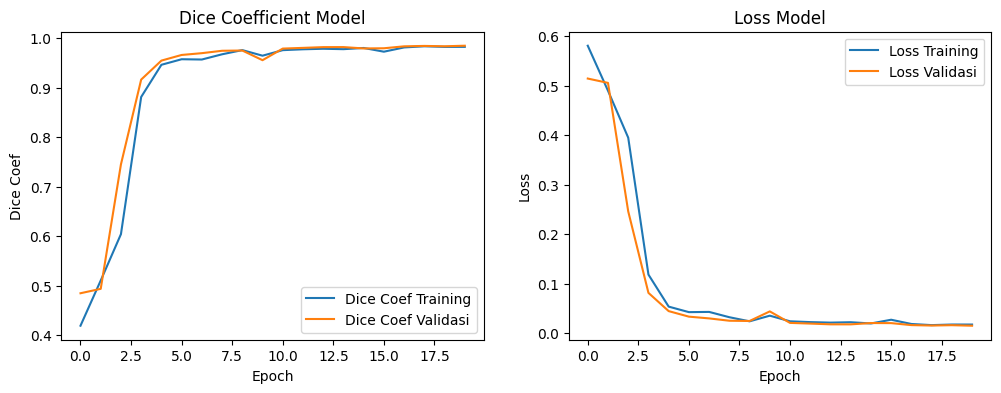

In [ ]:
# Plot hasil training model (monitoring)
# Plotting dice coef dan loss
plt.figure(figsize=(12, 4))

# Plot Dice Coefficient
plt.subplot(1, 2, 1)
plt.plot(history.history['dice_coef'], label='Dice Coef Training')
plt.plot(history.history['val_dice_coef'], label='Dice Coef Validasi')
plt.title('Dice Coefficient Model')
plt.xlabel('Epoch')
plt.ylabel('Dice Coef')
plt.legend()

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Loss Training')
plt.plot(history.history['val_loss'], label='Loss Validasi')
plt.title('Loss Model')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

## **Predict (Semantic Segmentation)**

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_18']
Received: inputs=Tensor(shape=(5, 128, 128, 3))
  warnings.warn(msg)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 469ms/step


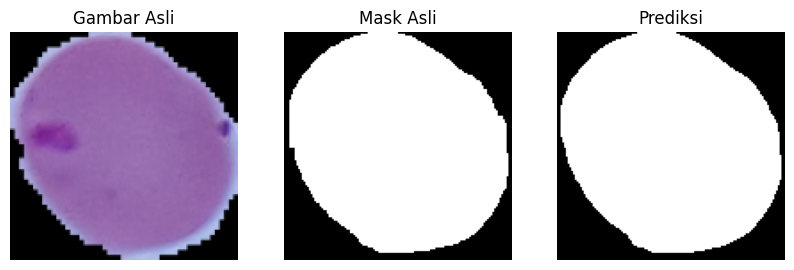

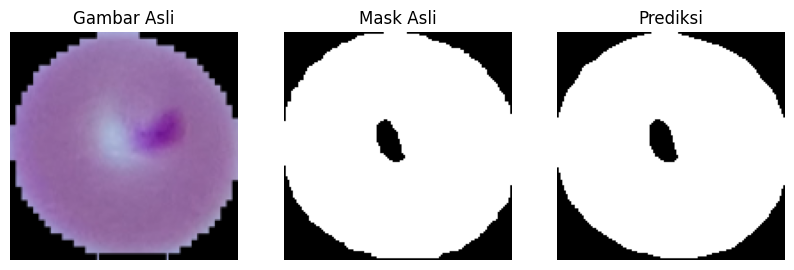

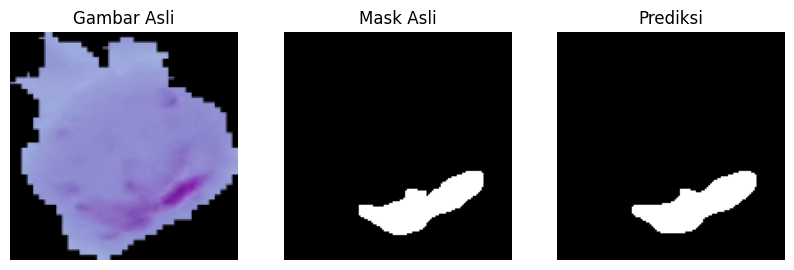

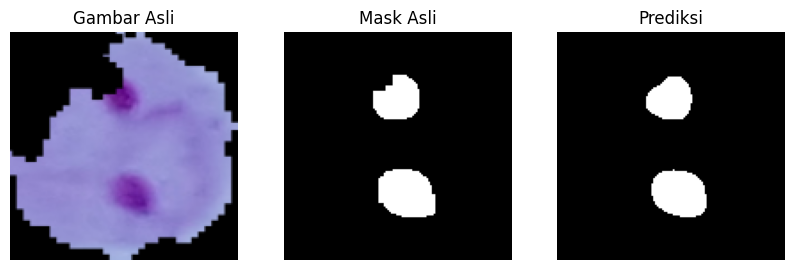

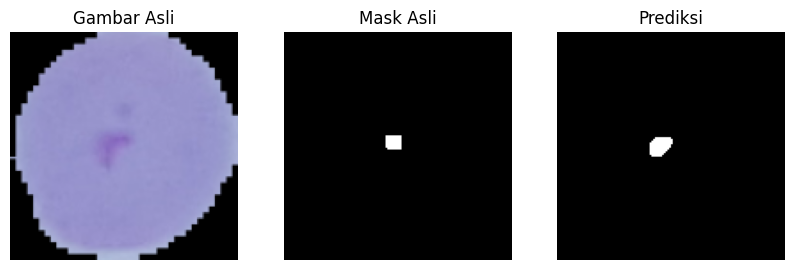

In [ ]:
# Membuat hasil prediksi area sel darah yang terinfeksi
preds = model.predict(X_val[:5])

# Menampilkan hasil prediksi
for i in range(5):
    plt.figure(figsize=(10, 3))

    plt.subplot(1, 3, 1)
    plt.imshow(X_val[i])
    plt.title("Gambar Asli")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(Y_val[i].squeeze(), cmap="gray")
    plt.title("Mask Asli")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow((preds[i].squeeze() > 0.5), cmap="gray")
    plt.title("Prediksi")
    plt.axis("off")

    plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 458ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


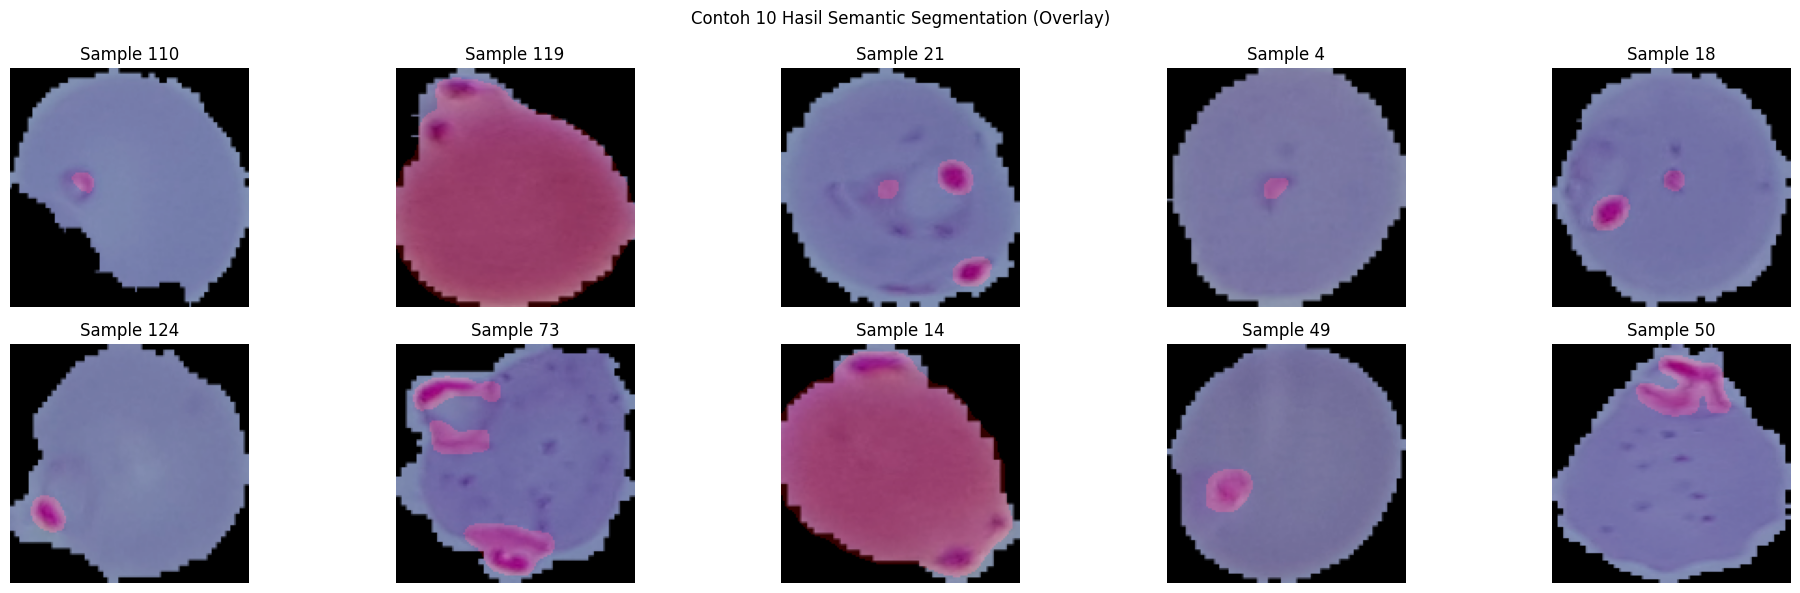

In [ ]:
# Membuat warna khusus di area yang terinfeksi
def overlay_mask(image, mask):
    color_mask = np.zeros_like(image)
    color_mask[:, :, 0] = mask * 255  # Channel Merah
    overlay = cv2.addWeighted(image.astype(np.uint8), 0.8, color_mask.astype(np.uint8), 0.2, 0)
    return overlay

# Pilih 10 indeks acak dari data validasi
random_indices = random.sample(range(len(X_val)), 10)

plt.figure(figsize=(20, 6))
for i, idx in enumerate(random_indices):
    current_pred = model.predict(np.expand_dims(X_val[idx], axis=0))
    original = (X_val[idx] * 255).astype(np.uint8)
    pred_mask = (current_pred[0].squeeze() > 0.5).astype(np.uint8)

    overlay = overlay_mask(original, pred_mask)

    plt.subplot(2, 5, i + 1)
    plt.imshow(overlay)
    plt.title(f"Sample {idx}")
    plt.axis("off")

plt.suptitle("Contoh 10 Hasil Semantic Segmentation (Overlay)")
plt.tight_layout()
plt.show()

## **Save U-Net Model**

In [ ]:
# Simpan model U-Net
model.save("unet_model.h5")